# Pipeline de Machine Learning com Communities and Crime (UCI)

Este notebook executa um pipeline completo de machine learning usando a base Communities and Crime do UCI, incluindo pré-processamento, treino, avaliação e visualização.

In [4]:
# Instalar dependências se necessário
import sys
import subprocess

def install(package):
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', package])

try:
    import ucimlrepo
except ImportError:
    install('ucimlrepo')
    import ucimlrepo

try:
    import sklearn
except ImportError:
    install('scikit-learn')
    import sklearn

try:
    import seaborn
except ImportError:
    install('seaborn')
    import seaborn

import pandas as pd
import numpy as np
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
# Buscar o dataset Communities and Crime do UCI
communities_and_crime = fetch_ucirepo(id=183)

# Carregar features (X) e targets (y) como DataFrames pandas
X = communities_and_crime.data.features
y = communities_and_crime.data.targets

# Se y for DataFrame com mais de uma coluna, escolher a primeira coluna numérica
if hasattr(y, 'columns') and len(y.columns) > 1:
    # Seleciona a primeira coluna numérica como target
    num_targets = y.select_dtypes(include=['number'])
    if not num_targets.empty:
        y = num_targets.iloc[:, 0]
    else:
        y = y.iloc[:, 0]

print(X.head())
if y is not None:
    print(y.head())
else:
    print('Atenção: O dataset não possui targets (y) definidos. Verifique a documentação do ucimlrepo para este dataset.')

# Mostrar metadata e variáveis
print(communities_and_crime.metadata)
print(communities_and_crime.variables)

   state county community        communityname  fold  population  \
0      8      ?         ?         Lakewoodcity     1        0.19   
1     53      ?         ?          Tukwilacity     1        0.00   
2     24      ?         ?         Aberdeentown     1        0.00   
3     34      5     81440  Willingborotownship     1        0.04   
4     42     95      6096    Bethlehemtownship     1        0.01   

   householdsize  racepctblack  racePctWhite  racePctAsian  ...  \
0           0.33          0.02          0.90          0.12  ...   
1           0.16          0.12          0.74          0.45  ...   
2           0.42          0.49          0.56          0.17  ...   
3           0.77          1.00          0.08          0.12  ...   
4           0.55          0.02          0.95          0.09  ...   

   PolicAveOTWorked  LandArea  PopDens  PctUsePubTrans  PolicCars  \
0              0.29      0.12     0.26            0.20       0.06   
1                 ?      0.02     0.12            

In [6]:
# Estatísticas descritivas e informações dos dados
print('Informações das features:')
X.info()
print(X.describe())
print('Informações dos targets:')
if y is not None:
    y.info()
    print(y.describe())
else:
    print('Atenção: O dataset não possui targets (y) definidos. Verifique a documentação do ucimlrepo para este dataset.')

Informações das features:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1994 entries, 0 to 1993
Columns: 127 entries, state to PolicBudgPerPop
dtypes: float64(99), int64(2), object(26)
memory usage: 1.9+ MB
             state         fold   population  householdsize  racepctblack  \
count  1994.000000  1994.000000  1994.000000    1994.000000   1994.000000   
mean     28.683551     5.493982     0.057593       0.463395      0.179629   
std      16.397553     2.873694     0.126906       0.163717      0.253442   
min       1.000000     1.000000     0.000000       0.000000      0.000000   
25%      12.000000     3.000000     0.010000       0.350000      0.020000   
50%      34.000000     5.000000     0.020000       0.440000      0.060000   
75%      42.000000     8.000000     0.050000       0.540000      0.230000   
max      56.000000    10.000000     1.000000       1.000000      1.000000   

       racePctWhite  racePctAsian  racePctHisp  agePct12t21  agePct12t29  ...  \
count   1994.0

In [7]:
# Padronizar colunas numéricas das features
# Substituir valores '?' por NaN antes de padronizar
X_clean = X.replace('?', np.nan)
# Converter todas as colunas possíveis para numérico
X_clean = X_clean.apply(pd.to_numeric, errors='ignore')
# Selecionar apenas colunas numéricas para padronização
num_cols = X_clean.select_dtypes(include=['number']).columns
scaler = StandardScaler()
X_scaled_num = pd.DataFrame(scaler.fit_transform(X_clean[num_cols].fillna(X_clean[num_cols].mean())), columns=num_cols, index=X_clean.index)
# Manter colunas não numéricas sem alteração
X_scaled = pd.concat([X_scaled_num, X_clean.drop(columns=num_cols)], axis=1)
print(X_scaled.head())

      state    county  community      fold  population  householdsize  \
0 -1.261697  0.000000   0.000000 -1.564227    1.043612      -0.814997   
1  1.483304  0.000000   0.000000 -1.564227   -0.453937      -1.853636   
2 -0.285697  0.000000   0.000000 -1.564227   -0.453937      -0.265129   
3  0.324303 -0.664357   2.178117 -1.564227   -0.138663       1.873246   
4  0.812304  0.446467  -2.477211 -1.564227   -0.375118       0.529125   

   racepctblack  racePctWhite  racePctAsian  racePctHisp  ...  LandArea  \
0     -0.630002      0.599578     -0.161288     0.111765  ...  0.500488   
1     -0.235335     -0.056219      1.418982    -0.318466  ... -0.413323   
2      1.224931     -0.793990      0.078147    -0.447535  ... -0.504705   
3      3.237730     -2.761379     -0.161288    -0.189397  ... -0.413323   
4     -0.630002      0.804514     -0.304949    -0.404512  ... -0.230561   

    PopDens  PctUsePubTrans  PolicCars  PolicOperBudg  LemasPctPolicOnPatr  \
0  0.133699        0.167316  -1.

C:\Users\Windows 11\AppData\Local\Temp\ipykernel_432\3720842110.py:5: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  X_clean = X_clean.apply(pd.to_numeric, errors='ignore')


In [8]:
# Remover linhas duplicadas
if y is not None:
    df = X_scaled.copy()
    df['target'] = y.values.squeeze()
    df_nodup = df.drop_duplicates().reset_index(drop=True)
    X_nodup = df_nodup.drop('target', axis=1)
    y_nodup = df_nodup['target']
    print(f'Após remoção de duplicatas: {X_nodup.shape[0]} linhas')
else:
    print('Atenção: O dataset não possui targets (y) definidos. Não é possível remover duplicatas considerando o target.')

Após remoção de duplicatas: 1994 linhas


In [9]:
# Dividir os dados em treino (60%), validação (20%) e teste (20%)
if y is not None and 'X_nodup' in globals() and 'y_nodup' in globals():
    X_train, X_temp, y_train, y_temp = train_test_split(X_nodup, y_nodup, test_size=0.4, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
    print(f'Treino: {X_train.shape}, Validação: {X_val.shape}, Teste: {X_test.shape}')
else:
    print('Atenção: Não foi possível dividir os dados porque X_nodup ou y_nodup não estão definidos. Verifique se o dataset possui targets (y) e se a célula de remoção de duplicatas foi executada com sucesso.')

Treino: (1196, 127), Validação: (399, 127), Teste: (399, 127)


In [10]:
# Treinar modelo RandomForestClassifier
# Remover colunas não numéricas antes de treinar o modelo
# Selecionar apenas colunas numéricas para o modelo
X_train_num = X_train.select_dtypes(include=['number'])
X_val_num = X_val.select_dtypes(include=['number'])
X_test_num = X_test.select_dtypes(include=['number'])

# Discretizar target para classificação binária (acima/abaixo da mediana)
if 'y_train' in globals():
    y_train_cat = (y_train > y_train.median()).astype(int)
    y_val_cat = (y_val > y_train.median()).astype(int)
    y_test_cat = (y_test > y_train.median()).astype(int)

    clf = RandomForestClassifier(random_state=42)
    clf.fit(X_train_num, y_train_cat)
else:
    print('Atenção: y_train não está definido. Verifique se a divisão dos dados foi executada com sucesso.')

In [11]:
# Treinar modelo RandomForestClassifier
# Remover colunas não numéricas antes de treinar o modelo
# Selecionar apenas colunas numéricas para o modelo
X_train_num = X_train.select_dtypes(include=['number'])
X_val_num = X_val.select_dtypes(include=['number'])
X_test_num = X_test.select_dtypes(include=['number'])

# Discretizar target para classificação binária (acima/abaixo da mediana)
if 'y_train' in globals():
    y_train_cat = (y_train > y_train.median()).astype(int)
    y_val_cat = (y_val > y_train.median()).astype(int)
    y_test_cat = (y_test > y_train.median()).astype(int)

    clf = RandomForestClassifier(random_state=42)
    clf.fit(X_train_num, y_train_cat)
else:
    print('Atenção: y_train não está definido. Verifique se a divisão dos dados foi executada com sucesso.')

Acurácia no teste: 0.83


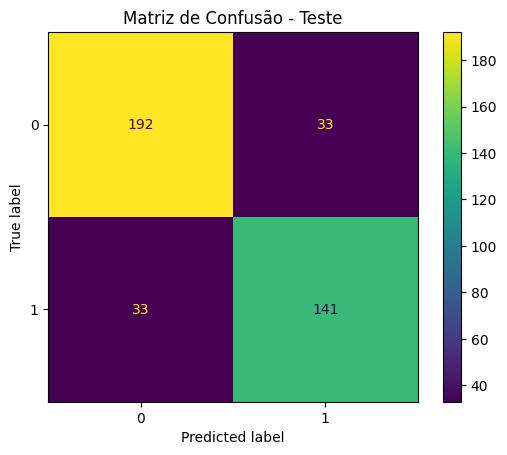

In [12]:
# Avaliar o modelo: matriz de confusão e acurácia no conjunto de teste
if 'clf' in globals() and 'X_test_num' in globals() and 'y_test_cat' in globals():
    y_pred = clf.predict(X_test_num)
    cm = confusion_matrix(y_test_cat, y_pred)
    acc = accuracy_score(y_test_cat, y_pred)
    print(f'Acurácia no teste: {acc:.2f}')
    ConfusionMatrixDisplay(cm).plot()
    plt.title('Matriz de Confusão - Teste')
    plt.show()
else:
    print('Atenção: O modelo (clf) ou os dados de teste não estão definidos. Verifique se as células anteriores foram executadas com sucesso.')